## Create a XGBoost Model

### 1) Import Standard Libraries

In [3]:
# import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import shap

/opt/anaconda3/envs/dsi_participant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2) Load the Dataset

In [5]:
# read in the csv file
df = pd.read_csv('sales_features.csv')

# display first 5 rows
df.head()

,Customer_ID,age_range,HolidayName,Month_name,jan_dummy,feb_dummy,mar_dummy,apr_dummy,may_dummy,jun_dummy,...,dummy_40_49,dummy_50_59,dummy_60_plus,gender_dummy,HolidayDummy,Max_Temp,Min_Temp,Mean_Temp,Total_Precip_mm,Product_Category
0,CUST015,40-49,0,1,1,0,0,0,0,0,...,1,0,0,0,0,1.8,-5.1,-1.7,0.1,Electronics
1,CUST065,50-59,0,12,0,0,0,0,0,0,...,0,1,0,1,0,3.1,0.3,1.7,0.1,Electronics
2,CUST072,20-29,0,5,0,0,0,0,1,0,...,0,0,0,0,0,19.5,10.0,14.8,0.0,Electronics
3,CUST074,Under 20,0,11,0,0,0,0,0,0,...,0,0,0,0,0,7.1,3.0,5.1,2.8,Beauty
4,CUST089,50-59,0,10,0,0,0,0,0,0,...,0,1,0,0,0,24.8,14.9,19.9,0.0,Electronics


### 5) Define Features (X) and Target (y)

In [23]:
X = df.loc[: , ['jan_dummy',
       'feb_dummy', 'mar_dummy', 'apr_dummy', 'may_dummy', 'jun_dummy',
       'jul_dummy', 'aug_dummy', 'sep_dummy', 'oct_dummy', 'nov_dummy',
       'dec_dummy', 'spend_3m', 'QTY_3m', 'spend_12m', 'QTY_12m',
       'dummy_under_20', 'dummy_20_29', 'dummy_30_39', 'dummy_40_49',
       'dummy_50_59', 'dummy_60_plus', 'gender_dummy', 'HolidayDummy',
       'Max_Temp', 'Min_Temp', 'Mean_Temp', 'Total_Precip_mm']]

from sklearn.preprocessing import LabelEncoder
# Encode y variable
y = LabelEncoder().fit_transform(df.loc[: , ['Product_Category']])

/opt/anaconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
X

,jan_dummy,feb_dummy,mar_dummy,apr_dummy,may_dummy,jun_dummy,jul_dummy,aug_dummy,sep_dummy,oct_dummy,...,dummy_30_39,dummy_40_49,dummy_50_59,dummy_60_plus,gender_dummy,HolidayDummy,Max_Temp,Min_Temp,Mean_Temp,Total_Precip_mm
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1.8,-5.1,-1.7,0.1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,3.1,0.3,1.7,0.1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,19.5,10.0,14.8,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7.1,3.0,5.1,2.8
4,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,24.8,14.9,19.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,14.0,3.9,9.0,0.0
996,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,26.1,15.3,20.7,0.0
997,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,10.1,3.7,6.9,0.6
998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5.6,3.5,4.6,0.0


In [31]:
y[:5]

array([2, 2, 2, 0, 2])

### Split into Train and Test Sets

In [32]:
# split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(
    X,
    y,
    train_size=0.8, 
    shuffle=True,
    random_state=42
)

### Define Hyperparameter Grid for Tuning

In [34]:
# define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5]
}

### Perform GridSearch with 5-Fold Cross Validation

In [35]:
# Initialize XGBoost Model
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=xgb_clf, 
    param_grid=param_grid, 
    scoring='accuracy',
    cv=5, 
    n_jobs=-1, # use all available CPU cores
    verbose=2)

In [36]:
# Fit GridSearchCV
grid_search.fit(train_x, train_y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(best_params)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.01, max_depth=

/opt/anaconda3/envs/dsi_participant/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'colsample_bytree': 0.5, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.8}


### Train the XGBoost Classifier with the Best Hyperparameters

In [37]:
# train the model with the best hyperparameters
optimized_xgb = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, **best_params) # if accuracy is low, try using softprob next

# fit the model
optimized_xgb.fit(train_x, train_y)

# make predictions
y_pred = optimized_xgb.predict(test_x)

# model evaluation
accuracy = accuracy_score(test_y, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# print classification report
print(classification_report(test_y, y_pred))

Accuracy: 0.34
              precision    recall  f1-score   support

           0       0.17      0.05      0.08        60
           1       0.32      0.44      0.37        66
           2       0.41      0.50      0.45        74

    accuracy                           0.34       200
   macro avg       0.30      0.33      0.30       200
weighted avg       0.31      0.34      0.31       200



### Get Feature Importance from XGBoost

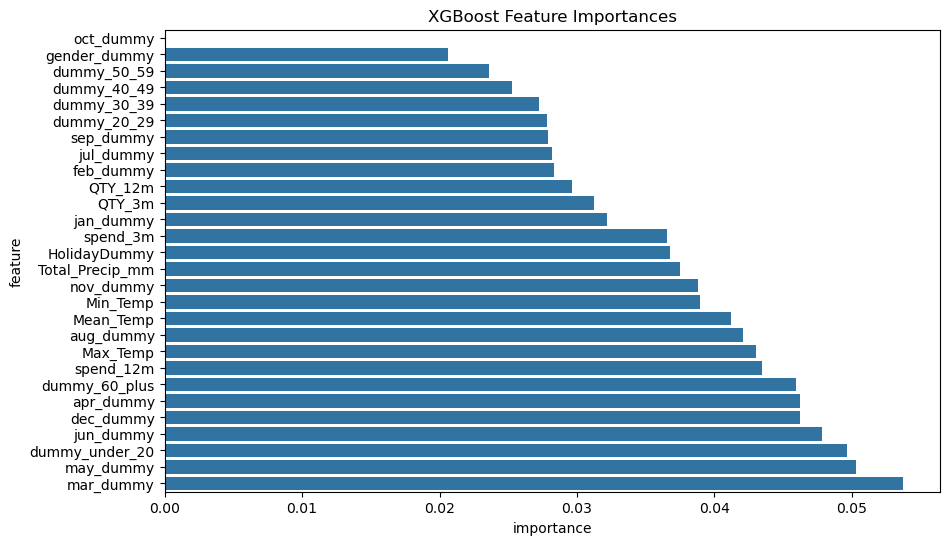

In [38]:
# get feature importance from the model
feature_names = optimized_xgb.feature_importances_

# create a dataframe of feature importances
feature_importances = pd.DataFrame({'feature': train_x.columns, 'importance': feature_names})

# sort feature importances
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

# plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('XGBoost Feature Importances')
plt.show()

### SHAP Values for Advanced Feature Importance

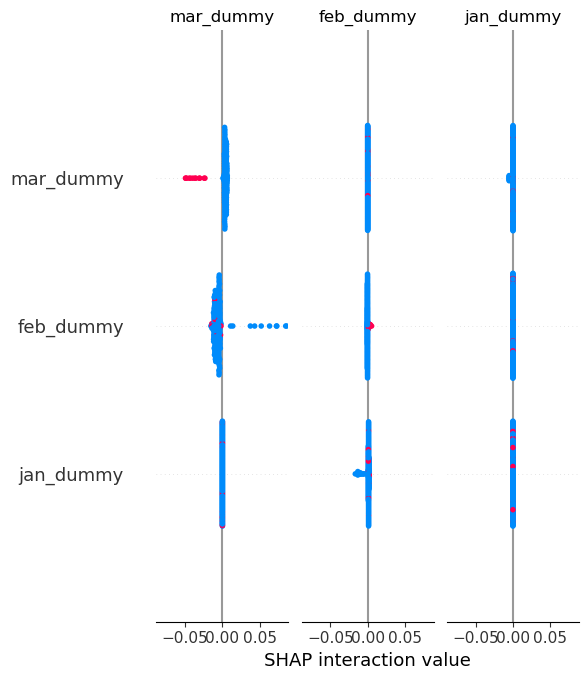

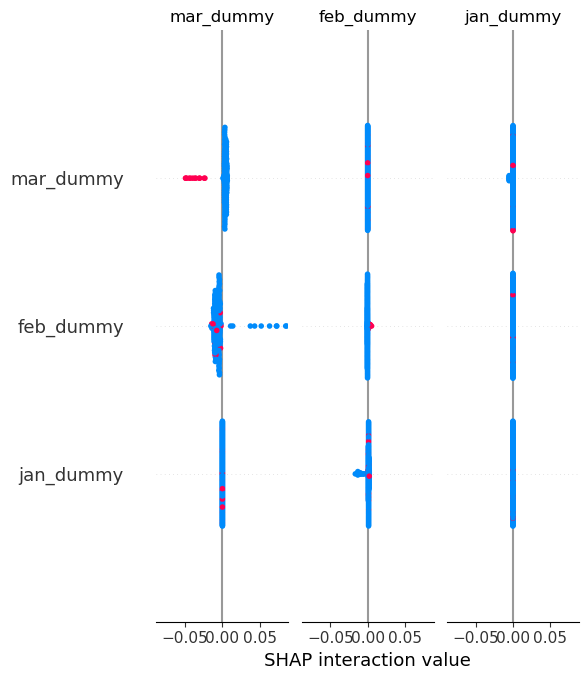

In [39]:
# explain model predictions using SHAP
explainer = shap.TreeExplainer(optimized_xgb, train_x)
shap_values = explainer.shap_values(test_x)

# plot SHAP values
shap.summary_plot(shap_values, test_x, plot_type='bar')

# detailed SHAP plot
shap.summary_plot(shap_values, test_x)